# Imports

In [1]:
from data_classes import LAQNData, HealthData, MetData, IncomeData, LondonGeoData
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from shapely.geometry import LineString
import requests
import geopandas as gpd
import numpy as np
import networkx as nx
import torch
import torch_geometric
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from tqdm import tqdm

/home/users/mwlw3/miniconda3/envs/AQmort/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


# Load datasets

In [2]:
species = "NO2"
region = "London"
NO2 = LAQNData(species, region)

In [3]:
income = IncomeData()

In [4]:
met = MetData("Heathrow")

In [5]:
geography = LondonGeoData()

In [6]:
mort = HealthData()

## LAQN

In [7]:
# daily_NO2_df = NO2.read("laqn-resample")
# daily_NO2_df.head(5)

Spatially aggregate the LAQN data at the local authority level, with implementation of the algorithm used in Schwartz, 2000:

In [8]:
# aggregated_NO2_df = NO2.local_authority_aggregation_and_log()
aggregated_NO2_df = NO2.read("laqn-local-authority")

(8401, 66)


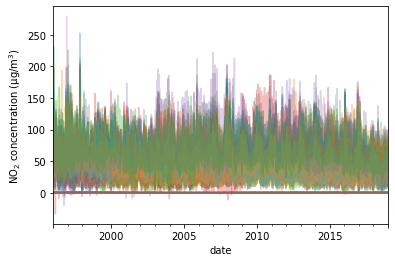

In [68]:
print(aggregated_NO2_df.shape)
aggregated_NO2_df.plot(alpha=0.3)
plt.legend().remove()
plt.ylabel("NO$_2$ concentration (µg/m$^3$)")
plt.xlabel("date")
plt.show()

## GDHI

In [10]:
daily_income_df = income.read("income-resample")

(7671, 33)


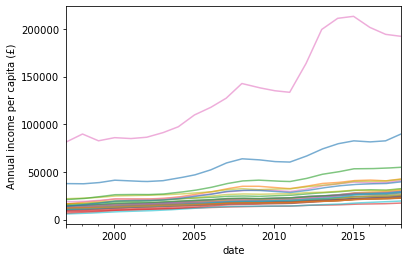

In [66]:
print(daily_income_df.shape)
daily_income_df.plot(alpha=0.6)
plt.legend().remove()
plt.ylabel("Annual income per capita (£)")
plt.xlabel("date")
plt.show()

Rename the local authorities in the income metadata using the LAQN metadata:

In [12]:
# income_metadata_df = income.rename_local_authority_districts_and_log(reference="use_LAQN")
income_metadata_df = income.read("income-metadata")

## Meteorology

In [13]:
# daily_met_df = met.resample_time_and_log(daily_income_df.index)
variables = ["temperature", "dew_point", "humidity", "precip", "wind_dir", "wind_speed", "peak_gust", "pressure"]
daily_met_df = met.read(variables, "met-resample")

(7671, 12)


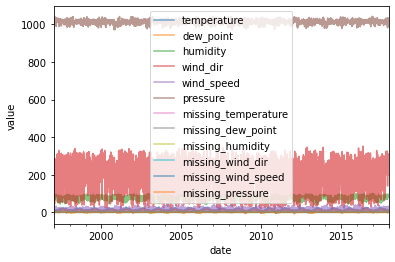

In [67]:
print(daily_met_df.shape)
daily_met_df.plot(alpha=0.6)
plt.ylabel("value")
plt.xlabel("date")
plt.show()

## London local authority shapefile

Rename the London local authorities shapefile using the income metadata:

In [15]:
# london_authorities_gdf = geography.download_and_log()
# london_authorities_gdf = geography.rename_local_authority_districts_and_log(income_metadata_df["local_authority"].tolist(), "GDHI")
# london_authorities_gdf = geography.read("london-local-authorities-renamed")

Identify neighbouring local authorities:

In [16]:
# london_authorities_gdf, edge_pairs = geography.get_local_authority_neighbour_edges_and_log()
london_authorities_gdf = geography.read("london-local-authorities-neighbours")
edge_pairs = geography.read("edge-pairs-array")

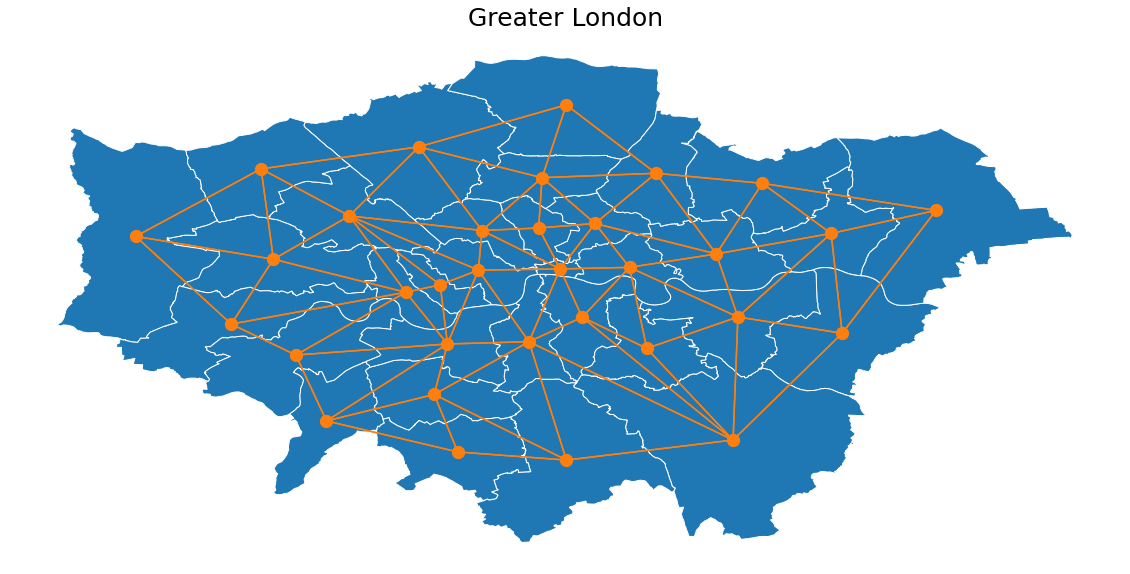

In [17]:
gdf = gpd.GeoDataFrame(edge_pairs.transpose(), columns=["x", "y"])
for column in gdf.columns:
    gdf[column] = gdf[column].map(london_authorities_gdf.centroid)
gdf.set_geometry([LineString(xy) for xy in zip(gdf.x, gdf.y)], inplace=True)

fig, ax = plt.subplots(figsize=(20, 15))
london_authorities_gdf.plot(ax=ax, edgecolors="w")
gdf.plot(ax=ax, color="tab:orange")
london_authorities_gdf.centroid.plot(ax=ax, marker="o", markersize=150, facecolors="tab:orange", edgecolors="tab:orange")
plt.axis("off")
plt.title("Greater London", fontsize=25)
plt.show()

## Mortality

In [18]:
mortality_df = mort.read("mortality-scaled")

(13698, 1)


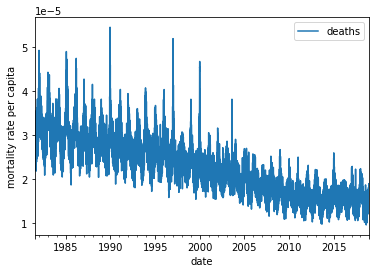

In [19]:
print(mortality_df.shape)
mortality_df.plot()
plt.ylabel("mortality rate per capita")
plt.xlabel("date")
plt.show()

# Missing data

## Check missing data (NaN values)

### LAQN

In [ ]:
len(aggregated_NO2_df)

In [ ]:
aggregated_NO2_df.isna().sum().plot.bar()
plt.title("LAQN NaN values")
# plt.yscale("log")
plt.show()

In [ ]:
local_authority = "Kingston"

In [ ]:
aggregated_NO2_df.mean(axis=1).plot(label="regional mean", alpha=0.5)
aggregated_NO2_df[local_authority].plot(alpha=0.7)
plt.legend()
plt.show()

#### Filling in data gaps using seasonal cycles and regional mean

##### Seasonal decomposition algorithm

In [ ]:
from statsmodels.api import tsa

In [ ]:
decomp_dict = {}

decomp = tsa.seasonal_decompose(aggregated_NO2_df.mean(axis=1).dropna(how="any"), model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})
decomp_dict["regional_mean"] = decomp_df

for la in aggregated_NO2_df.columns:
    decomp = tsa.seasonal_decompose(aggregated_NO2_df[la].dropna(how="any"), model="additive", period=365)
    decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})
    decomp_dict[la] = decomp_df
    decomp_dict[la].trend.plot(label=f"{la} trend", alpha=0.3)
    
decomp_dict["regional_mean"].trend.plot(label="regional mean trend")
# plt.legend(loc="upper right")
plt.title("Annual NO2 trends for local authorities and regional mean")
plt.show()


What if I use linear regression to map between the regional annual trend and the annual trends at the local authority level?

##### Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression

###### Annual trend

In [ ]:
df = pd.concat([decomp_dict["regional_mean"].trend, decomp_dict[local_authority].trend], axis=1)
df.columns = ["regional_mean", local_authority]
df.plot()
plt.title(f"Annual NO2 trends: {local_authority} local authority and regional mean")
plt.show()
x = df.dropna()["regional_mean"].values.reshape(-1,1)
y = df.dropna()[local_authority].values
model = LinearRegression().fit(x, y)
print("Model coefficient:", model.coef_[0])
x_predict = df.loc[df[local_authority].isna()].dropna(subset="regional_mean")["regional_mean"].values.reshape(-1,1)
y_predict = model.predict(x_predict)
trend_df = pd.DataFrame(y_predict, index=df.loc[df[local_authority].isna()].dropna(subset="regional_mean").index, 
                         columns=[f"{local_authority}_trend_predict"])
df = pd.concat([df, trend_df], axis=1)
df.plot()
plt.title("Annual NO2 trends and linear prediction using regional mean")
plt.show()

###### Seasonal component

In [ ]:
df = pd.concat([decomp_dict["regional_mean"].seasonal, decomp_dict[local_authority].seasonal], axis=1)
df.columns = ["regional_mean", local_authority]
df.plot(alpha=0.5)
plt.title(f"Seasonal NO2 components: {local_authority} local authority and regional mean")
plt.show()
x = df.dropna()["regional_mean"].values.reshape(-1,1)
y = df.dropna()[local_authority].values
model = LinearRegression().fit(x, y)
print("Model coefficient:", model.coef_[0])
x_predict = df.loc[df[local_authority].isna()].dropna(subset="regional_mean")["regional_mean"].values.reshape(-1,1)
y_predict = model.predict(x_predict)
seasonal_df = pd.DataFrame(y_predict, index=df.loc[df[local_authority].isna()].dropna(subset="regional_mean").index, 
                         columns=[f"{local_authority}_seasonal_predict"])
df = pd.concat([df, seasonal_df], axis=1)
df.plot(alpha=0.5)
plt.title("Seasonal NO2 components and linear prediction using regional mean")
plt.show()

In [ ]:
predict_df = pd.concat([aggregated_NO2_df[local_authority], trend_df, seasonal_df], axis=1) 
predict_df[f"{local_authority}_prediction"] = predict_df[f"{local_authority}_trend_predict"] + predict_df[f"{local_authority}_seasonal_predict"]

In [ ]:
predict_df[local_authority].plot(alpha=0.6)
predict_df[f"{local_authority}_prediction"].plot(alpha=0.6)
plt.legend()
plt.title("Filling NO2 data gaps using seasonal decomposition and linear regression")
plt.show()

I believe this doesn't work because I'm not including the residuals from the seasonal decomposition, which contribute a lot. So what if I just do a straight linear regression from the regional mean to the local authority concentration?

###### No decomposition

In [ ]:
regression_coefs = pd.DataFrame(columns=["local_authority", "coefficient"])

for local_authority in aggregated_NO2_df.columns:
    df = pd.concat([aggregated_NO2_df[local_authority], aggregated_NO2_df.mean(axis=1)], axis=1)
    df.columns = [local_authority, "regional_mean"]
    x = df.dropna()["regional_mean"].values.reshape(-1,1)
    y = df.dropna()[local_authority].values
    model = LinearRegression().fit(x, y)
    regression_coefs = pd.concat([regression_coefs, pd.DataFrame(data={"local_authority":[local_authority], "coefficient":[model.coef_[0]]})], ignore_index=True)

In [ ]:
regression_coefs.plot.scatter(x="local_authority", y="coefficient")
plt.xticks(rotation=90)
plt.title("Linear regression from regional mean to borough")
plt.show()

In [ ]:
local_authority = "City of London"
df = pd.concat([aggregated_NO2_df[local_authority], aggregated_NO2_df.mean(axis=1)], axis=1)
df.columns = [local_authority, "regional_mean"]
x = df.dropna()["regional_mean"].values.reshape(-1,1)
y = df.dropna()[local_authority].values
model = LinearRegression().fit(x, y)
x_predict = df.loc[df[local_authority].isna()].dropna(subset="regional_mean")["regional_mean"].values.reshape(-1,1)
y_predict = model.predict(x_predict)
predict_df = pd.DataFrame(y_predict, index=df.loc[df[local_authority].isna()].dropna(subset="regional_mean").index, 
                         columns=[f"{local_authority}_predict"])
df = pd.concat([df, predict_df], axis=1)
df.plot(alpha=0.6)
plt.title("NO$_2$ linear prediction using regional mean")
plt.show()

### Income data

In [ ]:
daily_income_df.isna().sum().sum()

No gaps in the GDHI dataset.

### Meteorological data

In [ ]:
len(daily_met_df)

In [ ]:
daily_met_df.isna().sum().plot.bar()
plt.title("Met data NaN values")
plt.yscale("log")
plt.show()

Exclude the precipitation and peak gust datasets.

### Mortality data

In [ ]:
mortality_df.isna().sum()

No gaps in the mortality dataset.

## Fill data gaps

### LAQN

One-hot encode the position of NaN values for each local authority, then fill the NaNs with the regional mean for that day:

In [38]:
print("NaN values before fill: ", aggregated_NO2_df.isna().sum().sum())
regional_mean_df = aggregated_NO2_df.mean(axis=1)

for local_authority in aggregated_NO2_df.columns:
    aggregated_NO2_df = pd.concat([aggregated_NO2_df, 
                                   pd.get_dummies(aggregated_NO2_df[local_authority].isna()).rename(columns={True:f"missing_{local_authority}"}).drop(False, axis=1)], 
                                  axis=1)
    aggregated_NO2_df[local_authority].fillna(regional_mean_df, inplace=True)

print("NaN values after fill: ", aggregated_NO2_df.isna().sum().sum())

NaN values before fill:  40434
NaN values after fill:  0


### Met data

Drop the precipiation and peak gust columns, as these have no data:

In [39]:
daily_met_df.drop(["precip", "peak_gust"], axis=1, inplace=True)

In [40]:
print("NaN values before fill: ", daily_met_df.isna().sum().sum())
for variable in daily_met_df.columns:
    daily_met_df = pd.concat([daily_met_df, pd.get_dummies(daily_met_df[variable].isna()).rename(columns={True:f"missing_{variable}"}).drop(False, axis=1)], axis=1)
daily_met_df.interpolate(inplace=True)
print("NaN values after fill: ", daily_met_df.isna().sum().sum())

NaN values before fill:  40
NaN values after fill:  0


# Graphs

## Graph visualisation

Set up the node connections:

In [41]:
edge_index = torch.tensor(edge_pairs, dtype=torch.long)

In [42]:
node_index = london_authorities_gdf.index.values.reshape(-1,1)
x = torch.tensor(node_index, dtype=torch.float)

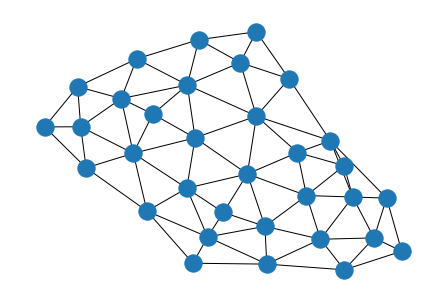

In [43]:
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
graph = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(graph)

## Input feature processing to arrays

In [44]:
def date_trim(df, start, end):
    df = df.loc[df.index >= start]
    df = df.loc[df.index <= end]
    return df

In [45]:
start, end = daily_income_df.index.min(), daily_income_df.index.max()

### LAQN and GDHI data at the local-authority level

In [46]:
aggregated_NO2_datetrim_df = date_trim(aggregated_NO2_df, start, end)

local_authority_list = [] 

for i in london_authorities_gdf.index:
    local_authority = london_authorities_gdf.iloc[i]["local_authority"]
    income_dataset_code = income_metadata_df.loc[income_metadata_df["local_authority"]==local_authority].index.values[0]
    daily_income_array = daily_income_df[income_dataset_code].values
    daily_NO2_array = aggregated_NO2_datetrim_df[local_authority].values
    nan_NO2_array = aggregated_NO2_datetrim_df[f"missing_{local_authority}"].values
    node_array = np.array([daily_NO2_array, nan_NO2_array, daily_income_array])
    local_authority_list.append(node_array)
input_array = np.array(local_authority_list)
print(input_array.shape)

(33, 3, 7671)


There are 33 local authority nodes, 3 input features (NO2, NO2 NaN encoding, income) and 7671 daily data points.

### Meteorological data at the regional level

In [47]:
for column in daily_met_df.columns:
    array = np.tile(daily_met_df[column].values, (len(london_authorities_gdf), 1, 1))
    input_array = np.concatenate((input_array, array), axis=1)

print(input_array.shape)

(33, 15, 7671)


There are now 12 additional input features: 6 meteorological variables and the NaN encoding for each variable.

## Target data processing to arrays

Trim the mortality dataset to the same time period as the inputs:

In [48]:
mortality_datetrim_df = date_trim(mortality_df, start, end)
target_array = mortality_datetrim_df.values
print(target_array.shape)

(7671, 1)


Scale the mortality rate to per 100,000:

In [49]:
mortality_datetrim_df["deaths"] = mortality_datetrim_df["deaths"]*100000

(7671, 1)


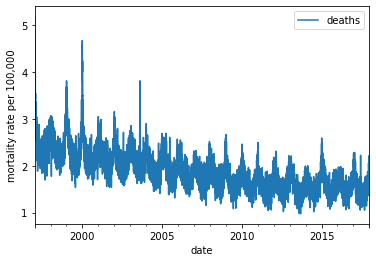

In [50]:
print(mortality_datetrim_df.shape)
mortality_datetrim_df.plot()
plt.ylabel("mortality rate per 100,000")
plt.xlabel("date")
plt.show()

## Torch geometric 

### Torch geometric data objects

In [51]:
# One datapoint:
i = 0
datapoint = torch_geometric.data.Data(x=torch.tensor(input_array[:, :, i]), edge_index=edge_index, y=torch.tensor(target_array[i]))

In [52]:
datapoint.num_node_features

15

This datapoint has 33 nodes with 15 input features; there are 164 directed edges (82 undirected edges); there is 1 target value for the graph.

### Torch geometric dataloaders

Can use torch geometric datasets e.g. `InMemoryDataset`, or pass a Python list holding `torch_geometric.data.Data` objects to `torch_geometric.loader.DataLoader`:

In [53]:
input_array.shape

(33, 15, 7671)

In [54]:
data_list = []

for i in range(len(target_array)):
    data_list.append(torch_geometric.data.Data(x=torch.from_numpy(input_array[:, :, i]).float(), 
                                               edge_index=edge_index, 
                                               y=torch.from_numpy(target_array[i]).float()))

In [55]:
batch_size = 1
loader = torch_geometric.loader.DataLoader(data_list, batch_size=batch_size, shuffle=True)

`InMemoryDataset` object:

In [56]:
# from torch_geometric.data import InMemoryDataset

# class BoroughMortalityDataset(InMemoryDataset):
#     def __init__(self, transform=None, pre_transform=None, pre_filter=None):
#         super().__init__(None, transform, pre_transform, pre_filter)
#         self.data, self.slices = torch.load(self.processed_paths[0])

#     @property
#     def raw_file_names(self):
#         return ['some_file_1', 'some_file_2', ...]

#     @property
#     def processed_file_names(self):
#         return ['data.pt']

#     def download(self):
#         # Download to `self.raw_dir`.
#         download_url(url, self.raw_dir)
#         ...

#     def process(self):
#         # Read data into huge `Data` list.
#         data_list = [...]

#         if self.pre_filter is not None:
#             data_list = [data for data in data_list if self.pre_filter(data)]

#         if self.pre_transform is not None:
#             data_list = [self.pre_transform(data) for data in data_list]

#         data, slices = self.collate(data_list)
#         torch.save((data, slices), self.processed_paths[0])

### Torch geometric GCN

Two `GCNConv` layers with defined `hidden_layer_size`; `global_add_pool` layer to aggregate over nodes to graph-level; `Linear` layer:

In [57]:
hidden_layer_size = 16

num_features = datapoint.num_node_features

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_layer_size)
        self.conv2 = GCNConv(hidden_layer_size, hidden_layer_size)
        self.output_layer = torch.nn.Linear(hidden_layer_size, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        x = torch_geometric.nn.global_add_pool(x=x, batch=None) # aggregate nodes to graph-level
        x = self.output_layer(x)

        return x.view(1) # flatten from (1, 1) to (1)

Check model works as expected:

In [58]:
model = GCN()
model = model.float()
for data in loader:
    out = model(data)

In [59]:
out.size()

torch.Size([1])

Run a training loop with defined `learning_rate` and `num_epochs`:

In [ ]:
learning_rate = 0.00001
num_epochs = 10

model = GCN().float()
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []

model.train()
for epoch in tqdm(range(num_epochs)):
    for data in loader:
        optimiser.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss_list.append(loss.data.numpy())
        loss.backward()
        optimiser.step()

 10%|█         | 1/10 [00:21<03:11, 21.28s/it]

Generate predictions:

In [ ]:
model.eval()
predictions = []

for data in loader:
    pred = model(data)
    predictions.append(pred.data.numpy())

In [ ]:
len(predictions)

In [ ]:
df = pd.DataFrame(predictions, columns=["prediction"])
df.index = mortality_datetrim_df.index
df.plot()
plt.ylabel("mortality per 100,000")
plt.xlabel("date")
plt.show()

In [ ]:
df = pd.DataFrame(loss_list, columns=["loss"])
df.plot()
plt.ylabel("MSE loss")
plt.xlabel(f"training data point ({num_epochs} epochs)")
plt.show()